In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle

In [5]:
file = open('output/fiducial_pt_full.pkl','rb')
fiducial = pickle.load(file)
file1 = open('output/label_full.pkl','rb')
label = pickle.load(file1)

In [32]:
# Plot the images
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

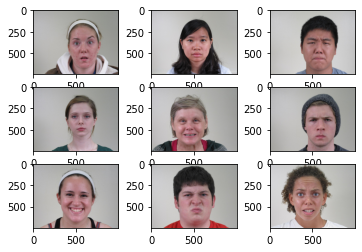

In [33]:
folder = 'train_set/images/000'
for i in range(1,10):
    plt.subplot(330+i)
    filename = folder + str(i) +'.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()

## Processing data
resize, downsample, and split into training and testing sets

In [8]:
# pre-process photo sizes
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [107]:
photos = []
folder = 'train_set/images/'
# enumerate files in the directory
for file in listdir(folder):
    photo = load_img(folder + file, target_size = (200,200))
    photo = img_to_array(photo)
    photos.append(photo)
# convert to numpy arrays
photos = asarray(photos)
labels = asarray(label)
print(photos.shape, labels.shape)
# save the reshaped photos
save('resized_image.npy',photos)

(3000, 200, 200, 3) (3000,)


In [108]:
from numpy import load
photos = load('resized_image.npy')
print(photos.shape)

(3000, 200, 200, 3)


In [109]:
import pandas as pd
pd.DataFrame(y_train)[0].value_counts()

0.0    492
1.0    464
Name: 0, dtype: int64

### downsampling

In [110]:
foo = pd.DataFrame(enumerate(labels))
index_maj = foo[foo[1] == 0][0]
index_min = foo[foo[1] == 1][0]

photo_maj = photos[index_maj] # 2402
photo_min = photos[index_min] # 598

In [111]:
from sklearn.utils import resample

In [112]:
photo_maj_down = resample(photo_maj, replace=False,     # sample without replacement
                                 n_samples=598,    # to match majority class
                                 random_state=123) # reproducible results
photos_bal = np.concatenate([photo_min,photo_maj_down])
photos_bal.shape

(1196, 200, 200, 3)

In [113]:
labels_bal = np.concatenate([np.ones(598),np.zeros(598)])
labels_bal.shape

(1196,)

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(photos_bal, labels_bal, test_size = 0.2)

In [115]:
X_train.shape, y_test.shape

((956, 200, 200, 3), (240,))

In [116]:
pd.DataFrame(y_test)[0].value_counts()

1.0    124
0.0    116
Name: 0, dtype: int64

In [117]:
pd.DataFrame(y_train)[0].value_counts()

0.0    482
1.0    474
Name: 0, dtype: int64

## CNN

In [93]:
# Initializing the model
model = keras.Sequential()
# Defining a convolutional layer
model.add(keras.layers.Conv2D(128, kernel_size = (5,5), activation = 'relu', input_shape = (100,100,3)))
model.add(keras.layers.Conv2D(64, kernel_size = (5,5), activation = 'relu'))
# Add our classificator
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation = 'relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10,activation = 'relu'))
model.add(keras.layers.Dense(2,activation = 'softmax'))
# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 0.001, decay = 0.01),
             metrics = ['accuracy','AUC'])

In [94]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 96, 96, 128)       9728      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 92, 92, 64)        204864    
_________________________________________________________________
flatten_9 (Flatten)          (None, 541696)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               138674432 
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_25 (Dense)             (None, 2)                

In [91]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_AUC', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [95]:
# Training of the model
model.fit(X_train, keras.utils.to_categorical(y_train),
         batch_size = 48, shuffle = True, epochs = 10, 
          validation_data = (X_test, keras.utils.to_categorical(y_test)),callbacks=[early_stopping])
# Evaluation of the model
scores = model.evaluate(X_test, keras.utils.to_categorical(y_test))
print('Loss:%.3f' %scores[0])
print('Accuracy: %.3f' %scores[1])

Train on 956 samples, validate on 240 samples
Epoch 1/10
956/956 [==============================] - 88s 92ms/sample - loss: 321.8948 - accuracy: 0.4937 - AUC: 0.4789 - val_loss: 0.6937 - val_accuracy: 0.4417 - val_AUC: 0.5000
Epoch 2/10
956/956 [==============================] - 84s 88ms/sample - loss: 0.6930 - accuracy: 0.5146 - AUC: 0.5161 - val_loss: 0.6940 - val_accuracy: 0.4417 - val_AUC: 0.4417
Epoch 3/10
956/956 [==============================] - 84s 88ms/sample - loss: 0.6930 - accuracy: 0.5146 - AUC: 0.5146 - val_loss: 0.6943 - val_accuracy: 0.4417 - val_AUC: 0.4417
Epoch 4/10
956/956 [==============================] - 84s 88ms/sample - loss: 0.6929 - accuracy: 0.5146 - AUC: 0.5146 - val_loss: 0.6943 - val_accuracy: 0.4417 - val_AUC: 0.4417
Epoch 5/10
956/956 [==============================] - 84s 88ms/sample - loss: 0.6929 - accuracy: 0.5146 - AUC: 0.5152 - val_loss: 0.6945 - val_accuracy: 0.4417 - val_AUC: 0.4417
Epoch 6/10
956/956 [==============================] - 87s 91ms

Loss:0.695
Accuracy: 0.442


Referencing this [paper](https://arxiv.org/pdf/1509.05371.pdf), we built a CNN with parallel feature extraction block (FeatEx). This model hit an accuracy of 98% identifying different emotions. However, it doesn't perform well in the signle/compound emotion recognition with training accuracy of 0.86 and testing accuracy of 0.45, worse than a random guess. 

In [142]:
def my_FeatCNN(input_shape,classes):
    padding = 'valid'
    img_input = keras.layers.Input(shape=input_shape)

    # START MODEL
    conv_1 = tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding=padding, activation='relu', name='conv_1')(img_input)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2), strides=(2,2))(conv_1)
    x = tf.keras.layers.BatchNormalization()(maxpool_1)
    
    # FEAT-EX1
    conv_2a = tf.keras.layers.Conv2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_2a')(x)
    conv_2b = tf.keras.layers.Conv2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_2b')(conv_2a)
    maxpool_2a = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2a')(x)
    conv_2c = tf.keras.layers.Conv2D(64, (1, 1), strides=(1,1), name='conv_2c')(maxpool_2a)
    concat_1 = tf.keras.layers.concatenate(inputs=[conv_2b,conv_2c], axis=3,name='concat2')
    maxpool_2b = keras.layers.MaxPooling2D((3,3), strides=(2,2), padding=padding, name='maxpool_2b')(concat_1)

    # FEAT-EX2
    conv_3a = tf.keras.layers.Conv2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_3a')(maxpool_2b)
    conv_3b = tf.keras.layers.Conv2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_3b')(conv_3a)
    maxpool_3a = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_3a')(maxpool_2b)
    conv_3c = tf.keras.layers.Conv2D(64, (1, 1), strides=(1,1), name='conv_3c')(maxpool_3a)
    concat_3 = tf.keras.layers.concatenate(inputs=[conv_3b,conv_3c],axis=3,name='concat3')
    maxpool_3b = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_3b')(concat_3)
    
    # FINAL LAYERS
    net = tf.keras.layers.Flatten()(maxpool_3b)
    net = tf.keras.layers.Dense(classes, activation='softmax', name='predictions')(net)
    
    # Create model.
    model = tf.keras.Model(img_input, net, name='deXpression')
    
    # Compile
    model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(),
             metrics = ['accuracy','AUC'])
    return model

In [146]:
input_shape = (200,200,3)
my_FeatCNN(input_shape,2).summary()

Model: "deXpression"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 98, 98, 256)  19456       input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 49, 49, 256)  0           conv_1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_78 (BatchNo (None, 49, 49, 256)  1024        max_pooling2d_12[0][0]           
________________________________________________________________________________________

In [143]:
my_FeatCNN(input_shape,2).fit(X_train, keras.utils.to_categorical(y_train),
         batch_size = 48, shuffle = True, epochs = 10, 
          validation_data = (X_test, keras.utils.to_categorical(y_test)),callbacks=[early_stopping])

Train on 956 samples, validate on 240 samples
Epoch 1/10
956/956 [==============================] - 47s 49ms/sample - loss: 12.3213 - accuracy: 0.4801 - AUC: 0.4757 - val_loss: 41.9291 - val_accuracy: 0.5167 - val_AUC: 0.5167
Epoch 2/10
956/956 [==============================] - 43s 45ms/sample - loss: 1.3617 - accuracy: 0.5335 - AUC: 0.5404 - val_loss: 8.1066 - val_accuracy: 0.5167 - val_AUC: 0.5167
Epoch 3/10
956/956 [==============================] - 43s 45ms/sample - loss: 0.8431 - accuracy: 0.5795 - AUC: 0.6079 - val_loss: 1.3242 - val_accuracy: 0.4750 - val_AUC: 0.4728
Epoch 4/10
956/956 [==============================] - 42s 44ms/sample - loss: 0.6335 - accuracy: 0.6444 - AUC: 0.7074 - val_loss: 0.8606 - val_accuracy: 0.5292 - val_AUC: 0.5183
Epoch 5/10
956/956 [==============================] - 41s 43ms/sample - loss: 0.5768 - accuracy: 0.6872 - AUC: 0.7618 - val_loss: 0.8929 - val_accuracy: 0.4917 - val_AUC: 0.5002
Epoch 6/10
956/956 [==============================] - 42s 44ms

In [144]:
scores = my_FeatCNN(input_shape, 2).evaluate(X_test, keras.utils.to_categorical(y_test))
print('Loss:%.3f' %scores[0])
print('Accuracy: %.3f' %scores[1])

240/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [138]:
def my_CNN(input_shape, num_classes):
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same',
                            name='image_array', input_shape=input_shape, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.25))
    model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.25))
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Convolution2D(filters=num_classes, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(num_classes, activation='softmax', name='predictions'))
    # compile
    model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(),
             metrics = ['accuracy','AUC'])
    print(model.summary())
    return model

In [139]:
input_shape = (200,200,3)
my_CNN(input_shape,2).fit(X_train, keras.utils.to_categorical(y_train),
         batch_size = 48, shuffle = True, epochs = 10, 
          validation_data = (X_test, keras.utils.to_categorical(y_test)),callbacks=[early_stopping])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 200, 200, 256)     7168      
_________________________________________________________________
batch_normalization_62 (Batc (None, 200, 200, 256)     1024      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 100, 100, 128)     295040    
_________________________________________________________________
batch_normalization_63 (Batc (None, 100, 100, 128)     512       
_________________________________________________________________
dropout_22 (Dropout)         (None, 100, 100, 128)     0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 50, 50, 64)        73792     
_________________________________________________________________
batch_normalization_64 (Batc (None, 50, 50, 64)      

In [140]:
scores = my_CNN(input_shape, 2).evaluate(X_test, keras.utils.to_categorical(y_test))
print('Loss:%.3f' %scores[0])
print('Accuracy: %.3f' %scores[1])

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 200, 200, 256)     7168      
_________________________________________________________________
batch_normalization_68 (Batc (None, 200, 200, 256)     1024      
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 100, 100, 128)     295040    
_________________________________________________________________
batch_normalization_69 (Batc (None, 100, 100, 128)     512       
_________________________________________________________________
dropout_24 (Dropout)         (None, 100, 100, 128)     0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 50, 50, 64)        73792     
_________________________________________________________________
batch_normalization_70 (Batc (None, 50, 50, 64)      

Loss:0.805
Accuracy: 0.521
